In [19]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pytesseract

In [20]:
'''
../../../Lumen_Image_Data/train/ISIC_0134357.jpg
../../../Lumen_Image_Data/train/ISIC_0082348.jpg
'''

'\n../../../Lumen_Image_Data/train/ISIC_0134357.jpg\n../../../Lumen_Image_Data/train/ISIC_0082348.jpg\n'

In [21]:
def remove_ruler(image_path, output_path=None):
    # Read image with OpenCV
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Create mask for inpainting
    mask = np.zeros(gray.shape, dtype=np.uint8)

    # PART 1: Detect lines using Hough Line Transform
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30, minLineLength=15, maxLineGap=10)

    line_regions = []  # Store regions where lines are detected

    if lines is not None and len(lines) > 0:
        print(f"Found {len(lines)} lines")

        # Add all detected lines to the mask with a thick stroke
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask, (x1, y1), (x2, y2), 255, thickness=7)

            # Track line regions for text detection later
            min_x = min(x1, x2) - 50  # Add padding
            max_x = max(x1, x2) + 50
            min_y = min(y1, y2) - 50
            max_y = max(y1, y2) + 50
            line_regions.append((min_x, min_y, max_x, max_y))

        # Merge overlapping line regions
        if line_regions:
            i = 0
            while i < len(line_regions):
                j = i + 1
                while j < len(line_regions):
                    x1, y1, x2, y2 = line_regions[i]
                    x3, y3, x4, y4 = line_regions[j]

                    # Check if regions overlap
                    if (x1 <= x4 and x2 >= x3 and y1 <= y4 and y2 >= y3):
                        # Merge regions
                        merged = (
                            max(0, min(x1, x3)),
                            max(0, min(y1, y3)),
                            min(img.shape[1], max(x2, x4)),
                            min(img.shape[0], max(y2, y4))
                        )
                        line_regions[i] = merged
                        line_regions.pop(j)
                    else:
                        j += 1
                i += 1

    # PART 2: Use Tesseract OCR to detect "mm" text
    # First, run Tesseract on the entire image
    custom_config = r'--oem 3 --psm 11 -c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.-'
    text_data = pytesseract.image_to_data(img_rgb, config=custom_config, output_type=pytesseract.Output.DICT)

    # Find all instances of "mm" or similar measurement text
    for i, text in enumerate(text_data['text']):
        text = text.lower()
        # Look for measurement indicators
        if any(unit in text for unit in ['mm', 'cm', 'nm', 'µm']) or text.isdigit():
            x = text_data['left'][i]
            y = text_data['top'][i]
            w = text_data['width'][i]
            h = text_data['height'][i]
            conf = text_data['conf'][i]

            # Only consider text with reasonable confidence
            if conf > 30 and w > 0 and h > 0:
                # Add detected text area to mask with padding
                cv2.rectangle(mask, (x-10, y-10), (x+w+10, y+h+10), 255, -1)
                print(f"Found text: '{text}' at ({x}, {y})")

    # PART 3: For each detected line region, also run OCR specifically in that area
    for region in line_regions:
        x1, y1, x2, y2 = [max(0, int(val)) for val in region]
        x2 = min(x2, img.shape[1])
        y2 = min(y2, img.shape[0])

        if x2 <= x1 or y2 <= y1:
            continue

        # Extract region around lines
        roi = img_rgb[y1:y2, x1:x2]
        if roi.size == 0:
            continue

        # Run OCR on the region with more focused settings
        roi_config = r'--oem 3 --psm 6'  # Assuming text is a single uniform block
        try:
            roi_text = pytesseract.image_to_string(roi, config=roi_config)
            roi_text = roi_text.lower().strip()

            # If meaningful text is found, mask the entire region
            if any(unit in roi_text for unit in ['mm', 'cm', 'nm', 'µm', 'm']):
                cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)
                print(f"Found measurement text in region: '{roi_text}'")
        except Exception as e:
            print(f"OCR error in region: {e}")

    # PART 4: Enhanced detection specifically for "mm" at the bottom of the image
    bottom_roi = img_rgb[int(img.shape[0]*0.85):, :]
    try:
        bottom_text = pytesseract.image_to_string(bottom_roi, config=custom_config)
        if 'mm' in bottom_text.lower():
            # If "mm" is found at bottom, add the region to mask
            print(f"Found 'mm' at image bottom: '{bottom_text}'")
            mask[int(img.shape[0]*0.85):, :] = 255
    except Exception as e:
        print(f"Bottom OCR error: {e}")

    # PART 5: Apply dilation to ensure complete coverage of detected elements
    kernel = np.ones((9, 9), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)

    # PART 6: Inpaint to remove ruler elements
    result = cv2.inpaint(img_rgb, mask, inpaintRadius=15, flags=cv2.INPAINT_TELEA)

    # Convert result to PIL Image
    pil_img = Image.fromarray(result)

    # Save if output path is specified
    if output_path:
        pil_img.save(output_path)
        print(f"Saved cleaned image to {output_path}")

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(result)
    plt.title("Cleaned Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return pil_img


In [22]:
def mask_dark_pixels(image_path, output_path=None, threshold=30):
    # Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Create mask - detect pixels darker than threshold
    _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)

    # Optional: Remove small noise from mask
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Apply mask - here we're inpainting the dark pixels
    # You could also use the mask for other operations
    result = cv2.inpaint(img_rgb, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(mask, cmap='gray')
    plt.title("Dark Pixels Mask")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(result)
    plt.title("Image with Dark Pixels Removed")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save result if output path is provided
    if output_path:
        Image.fromarray(result).save(output_path)

    return img_rgb, mask, result

In [23]:
# remove_ruler('../../../Lumen_Image_Data/train/ISIC_0082348.jpg', './cleaned_image.jpg')

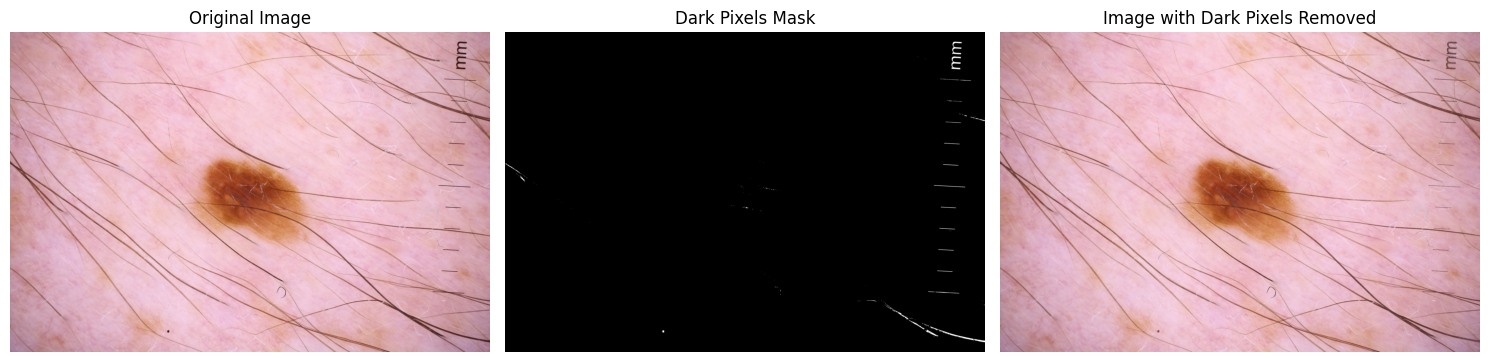

In [24]:
original, mask, processed = mask_dark_pixels('../../../Lumen_Image_Data/train/ISIC_0082348.jpg', 'processed.jpg', threshold=60)